In [1]:
#Visualize Samples from the model
import sys, os, glob
from collections import OrderedDict
sys.path.append('../../')
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['lines.linewidth']=5
mpl.rcParams['lines.markersize']=15
mpl.rcParams['text.usetex']=True
mpl.rcParams['text.latex.unicode']=True
mpl.rcParams['font.family'] = 'serif' 
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['text.latex.preamble']= ['\\usepackage{amsfonts}','\\usepackage{amsmath}']
mpl.rcParams['font.size'] = 30
mpl.rcParams['axes.labelsize']=30
mpl.rcParams['legend.fontsize']=30
#http://stackoverflow.com/questions/22408237/named-colors-in-matplotlib
from utils.misc import getConfigFile, readPickle, loadHDF5, getUniqueIDFromParams
from optvaeutils.viz import getName

In [2]:
evalData = loadHDF5('../../expt/evaluateIF_params/wikicorp-pl-2-finopt-if_eval.h5')
trainData = loadHDF5('../../expt/evaluateIF_params/wikicorp-pl-2-finopt-if_train.h5')
print trainData.keys()

[u'mu_f', u'logcov_0', u'data', u'logcov_f', u'mu_0']


In [3]:
from scipy.stats import spearmanr, pearsonr
from matplotlib.ticker import NullFormatter
def KL(mu_0, cov_0, mu_f, cov_f):
    assert np.all(cov_0>0.),'should be positive'
    assert np.all(cov_f>0.),'should be positive'
    diff_mu = mu_f-mu_0
    KL      = np.log(cov_f)-np.log(cov_0) - 1. + cov_0/cov_f + diff_mu**2/cov_f
    KL_t    = 0.5*KL.sum(1)
    return KL_t
def normalize(v):
    vmx, vmn = v.max(), v.min()
    return (v-vmn)/(vmx-vmn)

In [4]:
data        = trainData['data']
klvec_train = KL(trainData['mu_0'],np.exp(trainData['logcov_0']),trainData['mu_f'],np.exp(trainData['logcov_f']))
data              = data[:20000]
klvec_train        = klvec_train[:20000]
sums        = np.array(data.sum(0)).ravel()
widx_rare   = np.where(sums>1000)[0]
n_rare_words_train = data[:,widx_rare].sum(1)
print n_rare_words_train

[ 183.   47.  135. ...,   57.   17.  136.]


In [5]:
data              = evalData['data']
klvec_eval        = KL(evalData['mu_0'],np.exp(evalData['logcov_0']),evalData['mu_f'],np.exp(evalData['logcov_f']))

data              = data[:20000]
klvec_eval        = klvec_eval[:20000]
sums              = np.array(data.sum(0)).ravel()
widx_rare         = np.where(sums>1000)[0]
n_rare_words_eval = data[:,widx_rare].sum(1)
print n_rare_words_eval

[  43.  123.   45. ...,   18.   67.  209.]


(20000,)
SpearmanrResult(correlation=0.77488616471271576, pvalue=0.0)
SpearmanrResult(correlation=0.73151026646214856, pvalue=0.0)


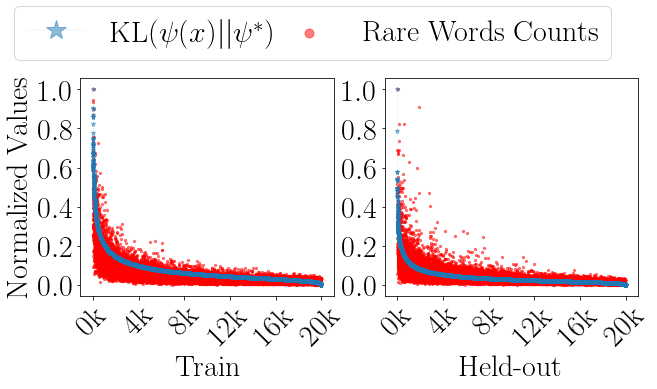

In [6]:
fig,axlist = plt.subplots(1,2,figsize=(10,4))

ax = axlist.ravel()[0]
idx_s = np.argsort(klvec_train)[::-1]
print idx_s.shape
ax.plot(np.arange(20000),normalize(klvec_train[idx_s]),alpha=0.5,marker='*',lw=0.1,ms=5)
ax.scatter(np.arange(20000),normalize(n_rare_words_train[idx_s]),alpha=0.5,s=5,c='r')
print spearmanr(n_rare_words_train, b=klvec_train)
ax.set_ylabel('Normalized Values')
ax.set_xlabel('Train')
    
ax = axlist.ravel()[1]
idx_s = np.argsort(klvec_eval)[::-1]
ax.plot(np.arange(20000),normalize(klvec_eval[idx_s]),alpha=0.5,marker='*',lw=0.1,ms=5,label='$\\text{KL}(\\psi(x)||\\psi^*)$')
ax.scatter(np.arange(20000),normalize(n_rare_words_eval[idx_s]),alpha=0.5,s=5,c='r',label='Rare Words Counts')
ax.legend(bbox_to_anchor=(0.95, 1.4), columnspacing=0.1, ncol=2, markerscale=4)
print spearmanr(n_rare_words_eval, b=klvec_eval)
ax.set_xlabel('Held-out')

for ax in axlist:
    ax.set_yticks(np.arange(0,1.1,0.2))
    plt.sca(ax)
    plt.xticks(np.arange(0,20001,4000),[str(k)+'k' for k in np.arange(0,20001,4000)/1000],rotation=45)
plt.savefig('normalized_kl_vs_docs.png',bbox_inches='tight')

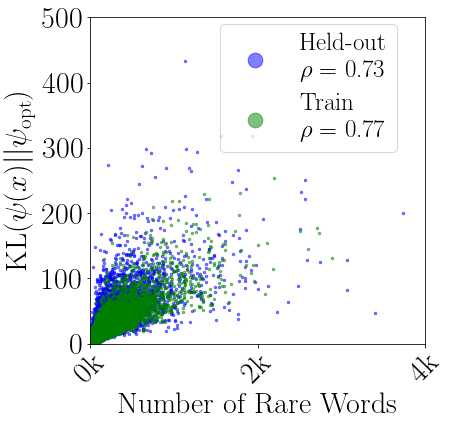

In [7]:
evall = 'Held-out\n$\\rho = $ %.2f'%(spearmanr(n_rare_words_eval, b=klvec_eval).correlation)
trainl = 'Train\n$\\rho = $ %.2f'%(spearmanr(n_rare_words_train, b=klvec_train).correlation)

plt.figure(figsize=(6,6))
plt.scatter(n_rare_words_eval,klvec_eval,s=6,c='b',alpha=0.5,label=evall)
plt.scatter(n_rare_words_train,klvec_train,s=6,c='g',alpha=0.5,label=trainl)
plt.xticks(np.arange(0,4001,2000),[str(k/1000)+'k' for k in np.arange(0,4001,2000)],rotation='45')
plt.yticks(np.arange(0,600,100))
plt.xlim([0,4000])
plt.ylim([0,500])
plt.xlabel('Number of Rare Words')
plt.ylabel('$\\text{KL}(\\psi(x)||\\psi_{\\text{opt}})$')
plt.legend(loc='best', bbox_to_anchor=(.35, 0.55),ncol=1,columnspacing=0.1, markerscale=6, prop={'size': 25},frameon=True)
plt.savefig('kl_n_rare_words.png',bbox_inches='tight')